# Convert image to frequency modulated line shaded SVG
This python program converts an image (specified by `in_filename` as a path or URL) to a line shaded SVG. The lines are sine waves with frequency modulated by the intensity of the input image. The number of sine waves and the frequency output scale can be modified with interactive sliders. The output image can be downloaded for use in XY plotters or laser cutters/engravers.

## Examples
Input image                | Output image  
:-------------------------:|:-------------------------:
![](example_1_in.jpg)      |  ![](example_1_out.svg)
![](example_2_in.jpg)      |  ![](example_2_out.svg)
![](example_3_in.jpg)      |  ![](example_3_out.svg)
![](example_4_in.png)      |  ![](example_4_out.svg)

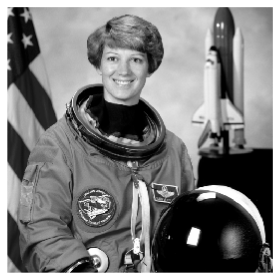

In [33]:
import matplotlib.pyplot as plt
from skimage import io, exposure, data
from skimage.color import rgb2gray
import math
import numpy as np
from ipywidgets import interactive, fixed, IntSlider, FloatSlider
import ipywidgets as widgets
from IPython.display import set_matplotlib_formats, display, FileLink, HTML

# Use SVG plots, since the lines are more clear (and we'll be exporting as SVG anyway)
set_matplotlib_formats("svg")

in_filename     = ""                     # Filename or URL
out_filename    = "output.svg"           # Filename for for output SVG
rows            = 64                     # Number of lines in output image
adjust_exposure = False                  # Can help balance some images

# Use the astronaut, Eileen Collins, if `in_filename` is empty
if in_filename != "":
    orig = io.imread(in_filename)
else:
    orig = data.astronaut()

# Convert to grayscale, since we only need an intensity (not color)
image = rgb2gray(orig)

plt.axis('off')
io.imshow(image)
io.show()

# Some images benefit from balancing exposure with the adjust_log function.
if adjust_exposure:
    image = exposure.adjust_log(image, 1)
    io.imshow(image)
    io.show()

In [34]:
# Split the image up into the number of rows specified by 'rows' and then average each group.
# Save the averaged rows over top of the original image, keeping the same dimensions.
# The last row group is not guaranteed to be the same size as the previous rows.
def mean_rows(image, rows):
    tmp_image = np.copy(image)

    for n in range(0, rows):
        px        = math.floor(tmp_image.shape[0]/rows) # Number of pixels in each row
        n_start   = n*px                                # Row start index
        n_end     = (n+1)*px                            # Row end index
        r         = tmp_image[n_start:n_end,:]          # All of the rows that will be averaged
        r_mean    = r.mean(0)                           # The average of the rows
        
        # Save over the rows we just averaged
        tmp_image[n_start:n_end,:] = r_mean
    return tmp_image

In [36]:
def make_lines(image, rows, new_min, new_max, filename=None):
    image       = mean_rows(image, rows)                # Average the rows of the image
    img_rows    = image.shape[0]                        # Number of rows in the image
    img_cols    = image.shape[1]                        # Number of columns in the image
    fs          = 10                                    # Spatial "sampling frequency". If lower, the processing 
                                                        #  will be faster, but at the sake of poorer spatial resolution 
                                                        #  (sine waves won't look like sine waves)
    x           = np.arange(0, img_cols, 1/fs)          # Corresponds to image width, with 'fs'-times as many values 
    phi         = np.zeros((rows, x.size))              # The phase of the sine waves
    rs          = np.arange(0, img_rows, img_rows/rows) # The indices of the rows that correspond to each averaged row
    rs          = rs.astype(int)                        # Inidces need to be integers
    frequencies = 1 - image[rs, :]                      # The frequencies come from the image pixel values (intensity)
    f_min       = frequencies.min()                     # Global min frequency
    f_max       = frequencies.max()                     # Global max frequency

    # Loop through each row, adjust the frequencies to the new min/max frequencies, and accumulate the phase.
    for r in range(0, rows):
        # Linearly scale the frequencies in to the new range.
        freqs = new_min + (new_max - new_min) / (f_max - f_min) * (frequencies[r, :] - f_min)
        
        # Initialize the frequency array to zeros
        f = np.zeros(x.size)

        # Loop through the f array and sample the value from the freqs array
        for n in range(0, f.size):
            f[n] = freqs[math.floor(n/fs)]

        # When stringing together sine waves with different frequencies, we can just change the frequency.
        # We need to keep track of the phase as well, since sine waves of different frequencies have different phases
        # at the same moment in time (or space in this case).
        # Here we take the cumulitive sum (adds up the values in f) and divides by the sample frequency to get the phase.
        phi[r, :] = np.cumsum(f) / fs

    # Initialize a new figure. You can change the figsize to increase or decrease the output image size.
    # TO DO: break out the figure size so that it can be changed parametrically.
    fig = plt.figure(figsize=(8,8))
    
    # Loop through and plot each sine wave
    for n in range(0, phi.shape[0]):
        # Amplitude should be less than 0.5 so waves don't overlap
        amp = 0.4     
        
        # Shift the wave down by the appropriate amount, so that none of the waves overlap
        shifted_wave = (img_rows/rows)*(-n + amp*np.sin(phi[n,:]))
        
        # Plot this wave. (All the other waves will be plotted to the same axis.)
        plt.plot(x, shifted_wave, color='black', linewidth=0.5)
        
    # Get the current axis so we can set the aspect ratio to 1.
    ax = plt.gca()
    ax.set_aspect(1)
    
    # Turn off the axis so that we don't save those lines too.
    plt.axis('off')
    
    # If filename is not None, then save the file and display a link for downloading it.
    if filename != None:
        plt.savefig(str(filename), bbox_inches='tight', pad_inches=0)
        link = f"<a href='{out_filename}' target='_blank' download>{out_filename}</a>"
        display(HTML(link))
        
    plt.show()
    return fig, (rows, new_min, new_max)

In [37]:
w = interactive(\
                make_lines,\
                image    = fixed(image),\
                rows     = IntSlider(  value = rows, min = 1,     max = 100,               continuous_update = False),\
                new_min  = FloatSlider(value = 0.01, min = 0.001, max = 1,   step = 0.001, continuous_update = False),\
                new_max  = FloatSlider(value = 2.5,  min = 0.001, max = 5,   step = 0.1,   continuous_update = False),\
                filename = fixed(None)\
               )
display(w)

interactive(children=(IntSlider(value=64, continuous_update=False, description='rows', min=1), FloatSlider(val…

## Save to file
Run the following cell to save the image to a file named `out_filename`. Click the link to download it.

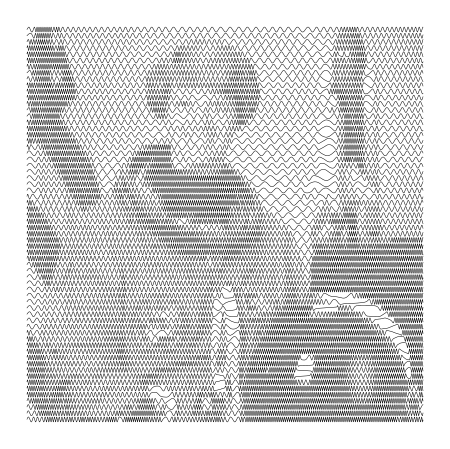

(<Figure size 576x576 with 1 Axes>, (64, 0.01, 2.5))

In [38]:
r, minf, maxf = w.result[1]
make_lines(image, r, minf, maxf, out_filename)